In [1]:
!pip install transformers
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 10.9 MB/s eta 0:00:00


In [2]:
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import tensorflow as tf
import utils
import keras_tuner as kt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Dropout, GlobalMaxPool1D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, TFAutoModel
from decimal import Decimal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Preprocessing

The primary data for the competition is, in each provided file, the comment_text column. This contains the text of a comment which has been labeled as Conspiratorial (1) or non-conspiratorial (0). The train set’s comments are entirely in Italian with sporadic citation of external resources in English and come exclusively from Telegram Channels.

The subtaskA_train.csv contains a conspiratorial column that it is the target to be trained on. The values of such column are either 1 indicating that the corresponding comment in comment_text column is Conspiratorial. Otherwise it is 0.

## Loading dataset

In [23]:
train = pd.read_csv("subtaskA_train_set.csv")
val = pd.read_csv("subtaskA_val_set.csv")
test = pd.read_csv("subtaskA_test_set.csv")
trainval = pd.read_csv("subtaskA_trainval_set.csv")

y_test = test["conspiratorial"]

# Creating model

## Initializing tokenizer and Bert pretrained model

In this notebook we experiment the [RoBERTa](https://huggingface.co/osiria/roberta-base-italian) model for the Italian language.

In [5]:
pre_trained_model = "osiria/roberta-base-italian"

tokenizer = AutoTokenizer.from_pretrained(pre_trained_model)

# initialize multilingual uncased RoBERTa model
bert = TFAutoModel.from_pretrained(pre_trained_model, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [24]:
SEQ_LEN = 256  # we will cut/pad our sequences to a length of 256 tokens
BATCH_SIZE = 32  # we will use batches of 32

def tokenize(sentence):
    tokens = tokenizer.encode_plus( # Tokenize and prepare for the model a sequence or a pair of sequences.
        sentence, # string to be encoded
        max_length=SEQ_LEN, # max length to consider for truncation/padding
        truncation=True, # truncate to max_length
        padding='max_length', # Pad to a maximum length specified
        add_special_tokens=True, # encode special tokens
        return_attention_mask=True, # return attention mask
        return_token_type_ids=False, # don't return token type IDs
        return_tensors='tf'
    )
    return tokens['input_ids'], tokens['attention_mask']

In [25]:
# create a mapping function that we use to restructure our dataset
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids, 'attention_mask': masks}, labels

def create_dataset(df):
  # initialize two arrays for input tensors
  Xids = np.zeros((len(df['comment_text']), SEQ_LEN))
  Xmask = np.zeros((len(df['comment_text']), SEQ_LEN))

  for i, sentence in enumerate(df['comment_text']):
    Xids[i, :], Xmask[i, :] = tokenize(sentence)

  labels= df['conspiratorial']

  # load arrays into tensorflow dataset
  dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

  # using map method to apply map_func to dataset
  dataset = dataset.map(map_func)

  # batch data
  return dataset.batch(BATCH_SIZE)

train = create_dataset(train) # training set
val = create_dataset(val) # validation set
train_val = create_dataset(trainval) # training and validation set (for final retraining)
test = create_dataset(test) # test set

## Defining model architecture

In [8]:
def build_model_with_hp(lstm_units, l1_units, l2_value, dropout_rate, learning_rate, clipnorm):
  input_ids = Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
  mask = Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

  # we consume the last_hidden_state tensor from bert (discarding pooled_outputs)
  embeddings = bert(input_ids, attention_mask=mask)[0]

  # BI-LSTM layer
  net = Bidirectional(
      LSTM( units = lstm_units, kernel_regularizer=regularizers.L2(l2_value), return_sequences= True)
      )(embeddings)
  net = GlobalMaxPool1D()(net)
  net = Dropout(dropout_rate)(net)

  # FULLY CONNECTED DENSE LAYERS
  net = Dense(
      units = l1_units,
      kernel_regularizer = regularizers.L2(l2_value),
      activation='relu')(net)
  net = Dropout(dropout_rate)(net)
  net = Dense(1, activation='sigmoid', name='outputs')(net)

  model = Model(inputs=[input_ids, mask], outputs=net)

  # set up bert not trainable
  model.layers[2].trainable = False

  optimizer = Adam(
    learning_rate=learning_rate,
    clipnorm=clipnorm
  )

  model.compile(
    optimizer = optimizer,
    loss="binary_crossentropy",
    metrics=['accuracy']
  )

  return model

def build_model(hp):
  return build_model_with_hp(
      lstm_units = hp.Choice("Bidirectional LSTM units", values=[8, 16, 32]),
      l1_units = hp.Choice("Dense layer 1 units", values=[8, 16, 32]),
      l2_value = hp.Choice("L2 regularization", values=[1e-4, 1e-5, 1e-6]),
      dropout_rate = hp.Choice("Dropout rate", values=[0.1, 0.2, 0.25]),
      learning_rate = hp.Choice("Learning rate", values=[1e-2, 1e-3]),
      clipnorm = 0.1
  )


# Training of the model

In [ ]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    max_trials=6,
    objective='val_accuracy',
    overwrite=True
)

Along the model, we introduce 2 callbacks to support the model training:

*   **ReduceLROnPlateau**: Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
*   **EarlyStopping**: Stop training when a monitored metric has stopped improving.



In [9]:
reduceLr_callback = tf.keras.callbacks.ReduceLROnPlateau(
  monitor="val_accuracy",
  factor=5e-2,
  patience=5,
  mode="auto",
  min_delta=1e-4,
  min_lr=1e-5
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='auto',
    patience=20,
    verbose=False,
    restore_best_weights=True
)

In [ ]:
tuner.search(
    x = train,
    epochs = 80,
    validation_data = val,
    callbacks = [
        reduceLr_callback,
        early_stopping
    ]
)

Trial 4 Complete [00h 20m 05s]
val_accuracy: 0.7108433842658997

Best val_accuracy So Far: 0.7650602459907532
Total elapsed time: 02h 03m 13s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
16                |16                |Bidirectional LSTM units
16                |16                |Dense layer 1 units
1e-05             |1e-05             |L2 regularization
0.1               |0.2               |Dropout rate
0.01              |0.01              |Learning rate

Epoch 1/80
42/42 [==============================] - 66s 1s/step - loss: 0.6743 - accuracy: 0.5949 - val_loss: 0.6498 - val_accuracy: 0.6536 - lr: 0.0100
Epoch 2/80
42/42 [==============================] - 33s 800ms/step - loss: 0.6394 - accuracy: 0.6425 - val_loss: 0.6445 - val_accuracy: 0.6325 - lr: 0.0100
Epoch 3/80
42/42 [==============================] - 44s 1s/step - loss: 0.6063 - accuracy: 0.6825 - val_loss: 0.6070 - val_accuracy: 0.7108 - lr: 0.0100
Epoch 4/80
42/42 [=================

In [15]:
model = build_model_with_hp(
  lstm_units = 16,
  l1_units = 16,
  l2_value = 1e-6,
  dropout_rate = 0.1,
  learning_rate = 1e-3,
  clipnorm = 0.1
)
history = model.fit(
    x = train,
    validation_data = val,
    batch_size=64,
    epochs=30,
    callbacks = [
        reduceLr_callback
    ]
)

Epoch 1/30
42/42 [==============================] - 61s 967ms/step - loss: 0.6698 - accuracy: 0.6032 - val_loss: 0.6792 - val_accuracy: 0.5181 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - 36s 859ms/step - loss: 0.6441 - accuracy: 0.6455 - val_loss: 0.6808 - val_accuracy: 0.5060 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - 36s 860ms/step - loss: 0.6306 - accuracy: 0.6591 - val_loss: 0.6693 - val_accuracy: 0.5452 - lr: 0.0010
Epoch 4/30
42/42 [==============================] - 36s 860ms/step - loss: 0.6112 - accuracy: 0.6795 - val_loss: 0.6530 - val_accuracy: 0.6265 - lr: 0.0010
Epoch 5/30
42/42 [==============================] - 36s 859ms/step - loss: 0.5893 - accuracy: 0.6954 - val_loss: 0.6448 - val_accuracy: 0.6114 - lr: 0.0010
Epoch 6/30
42/42 [==============================] - 36s 860ms/step - loss: 0.5615 - accuracy: 0.7166 - val_loss: 0.6232 - val_accuracy: 0.6687 - lr: 0.0010
Epoch 7/30
42/42 [==============================] - 36s 859ms/st

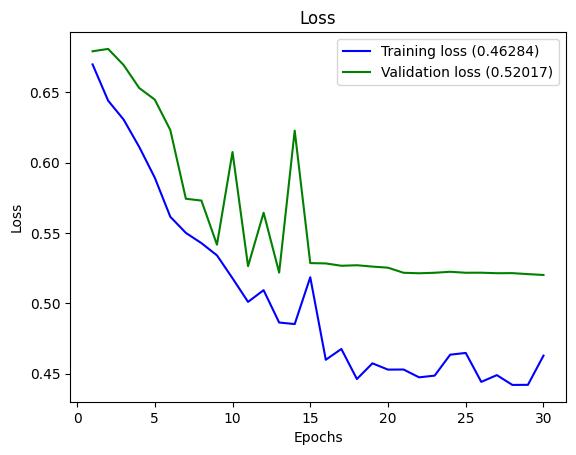

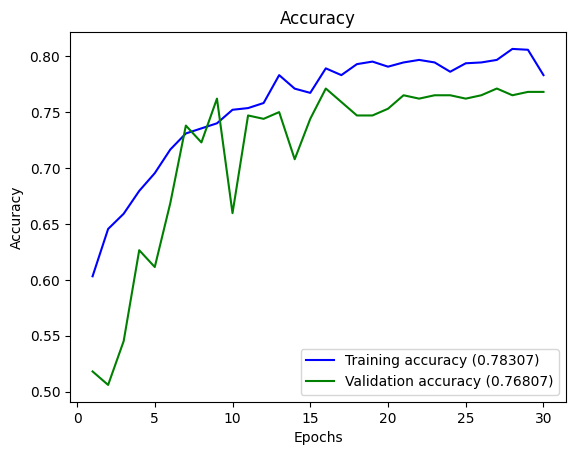

In [16]:
utils.plot_history(history)

# Final phase: retrain and test

## Retrain on training and validation

Training the model on the best hyperparams found by the random search

In [17]:
final_model = build_model_with_hp(
  lstm_units = 16,
  l1_units = 16,
  l2_value = 1e-6,
  dropout_rate = 0.1,
  learning_rate = 1e-3,
  clipnorm = 0.1
)

max_epochs = 17 # depends on the epochs reached by the best model before overfitting

In [18]:
final_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124956672  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

In [19]:
history = final_model.fit(
    x = train_val,
    batch_size=64,
    epochs=max_epochs
)

Epoch 1/17
52/52 [==============================] - 65s 643ms/step - loss: 0.6691 - accuracy: 0.5903
Epoch 2/17
52/52 [==============================] - 32s 611ms/step - loss: 0.6293 - accuracy: 0.6550
Epoch 3/17
52/52 [==============================] - 32s 620ms/step - loss: 0.6172 - accuracy: 0.6677
Epoch 4/17
52/52 [==============================] - 32s 615ms/step - loss: 0.5847 - accuracy: 0.6997
Epoch 5/17
52/52 [==============================] - 32s 611ms/step - loss: 0.5701 - accuracy: 0.7106
Epoch 6/17
52/52 [==============================] - 32s 615ms/step - loss: 0.5580 - accuracy: 0.7227
Epoch 7/17
52/52 [==============================] - 32s 617ms/step - loss: 0.5458 - accuracy: 0.7366
Epoch 8/17
52/52 [==============================] - 32s 618ms/step - loss: 0.5249 - accuracy: 0.7462
Epoch 9/17
52/52 [==============================] - 32s 614ms/step - loss: 0.5273 - accuracy: 0.7378
Epoch 10/17
52/52 [==============================] - 32s 612ms/step - loss: 0.5153 - accura

In [28]:
_ = final_model.evaluate(
    x = test,
    batch_size=64
)

6/6 [==============================] - 3s 544ms/step - loss: 0.4893 - accuracy: 0.7946


6/6 [==============================] - 3s 536ms/step


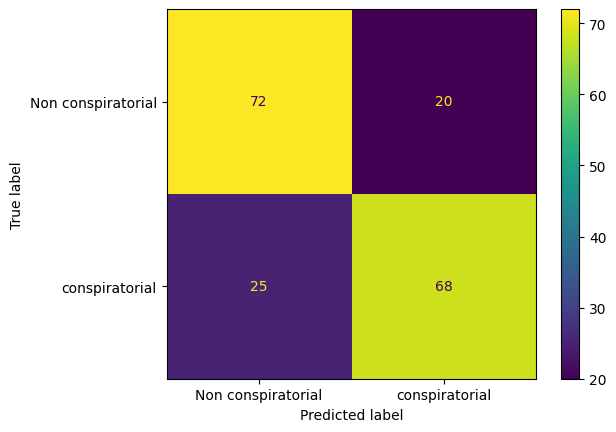

In [27]:
predictions = model.predict(x=test)
predictions = list(map(round, [ _[0] for _ in predictions]))
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non conspiratorial", "conspiratorial"])
disp.plot()